In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

In [6]:
ceph_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.tsv", separator='\t')

In [7]:
%%time
reads_df_list = \
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + \
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + \
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(ceph_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]


9it [00:00, 2778.71it/s]
6it [00:00, 3709.58it/s]
16it [00:00, 2855.70it/s]

CPU times: user 27 ms, sys: 6.45 ms, total: 33.5 ms
Wall time: 18.3 ms


## Subset of reads with at least 3 SNPs and a GC

In [8]:
%%time

fields = [
    'read_name',
    'read_length',
    'chrom',
    'sample_id',
    'grch37_chromosome_size_in_bp',
    'high_quality_snp_positions',
    "high_quality_snp_positions_alleles",
    "high_quality_snps_idx_transitions",
    'CO_active_interval_start',
    'CO_active_interval_end',
    'CO_active_interval_length_bp',
    'NCO_active_interval_start',
    'NCO_active_interval_end',
    'NCO_active_interval_length_bp',
    'grch37_reference_start',
    'grch38_reference_start',
    'grch37_reference_end',
    'grch38_reference_end',
    'T2T_reference_start',
    'grch37_reference_start_cM',
    'grch37_reference_end_cM',
    'CO_active_interval_start_cM',
    'CO_active_interval_end_cM',
    'CO_active_interval_crossover_prob',
    'NCO_active_interval_start_cM',
    'NCO_active_interval_end_cM',
    'NCO_active_interval_crossover_prob',
    "NCO_prob_detection_in_CO_active_interval",
    "full_read_crossover_prob",
    'AA_motif_center_pos',
    'AA_heat',
    'AA_motif_strand',
    'CL4_motif_center_pos',
    'CL4_heat',
    'CL4_motif_strand',
    'is_high_quality_read', 
    "high_quality_classification_class",
    "snp_positions_on_read", 
    "idx_transitions",
    "high_quality_classification_in_detectable_class",
    "H3K4me3_signal_mean",
    "CTCF_signal_mean",  
    "total_mismatches",
    "is_contamination",
]

def F(reads_df):
    return (reads_df
        .select(fields)           
        .filter(pl.col("high_quality_classification_class") == "GC")
        .collect()
        .filter(~pl.col("is_contamination"))
        .filter(pl.col("is_high_quality_read"))
        .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
        .filter(pl.col("CO_active_interval_crossover_prob") > 0)
        .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)    
        .select(fields)
    )

dense_reads_with_detection_df = pl.concat(
    joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(F)(reads_df) for reads_df in reads_df_list
    )
)

/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | e

CPU times: user 1.97 s, sys: 1.32 s, total: 3.28 s
Wall time: 1min 13s


[Parallel(n_jobs=-1)]: Done 682 out of 682 | elapsed:  1.2min finished


In [9]:
NCO_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_classification_class") == "GC")
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch37_first_converted_marker_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
        grch38_first_converted_marker_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
        grch37_genetic_length_cM = pl.col("grch37_reference_end_cM") - pl.col("grch37_reference_start_cM"),
    )
    .with_columns(
        n_converted = pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first(),
        upper_bound = (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))
        ),
        high_quality_upper_bound = (
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
        ),
        dataset = (
            pl.when(pl.col("sample_id").is_in(rahbari_sample_ids))
            .then(pl.lit("TwinsUK"))
            .otherwise(
                pl.when(pl.col("sample_id").is_in(sudmant_sample_ids))
                .then(pl.lit("SL"))
                .otherwise(pl.lit("CEPH"))
            )
        )
    )
)

dfs = []
for [chrom], df in NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
            grch37_first_converted_marker_poses_rate = rate_map.get_rate(df["grch37_first_converted_marker_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
            grch37_cM_per_bp_across_read = pl.col("grch37_genetic_length_cM") / pl.col("read_length"),
        )
    )
    
NCO_df = pl.concat(dfs)


In [10]:
NCO_df.group_by("dataset").len()

dataset,len
str,u32
"""CEPH""",911
"""TwinsUK""",1200
"""SL""",738


In [11]:
x1 = (NCO_df
    .filter(pl.col("dataset") != "CEPH")
    .filter(pl.col("n_converted") == 1)
    ["CO_active_interval_crossover_prob"]*1e2
).log(base=10)

In [12]:
xg1 = (NCO_df
    .filter(pl.col("dataset") != "CEPH")       
    .filter(pl.col("n_converted") > 1)
    ["CO_active_interval_crossover_prob"]*1e2
).log(base=10)

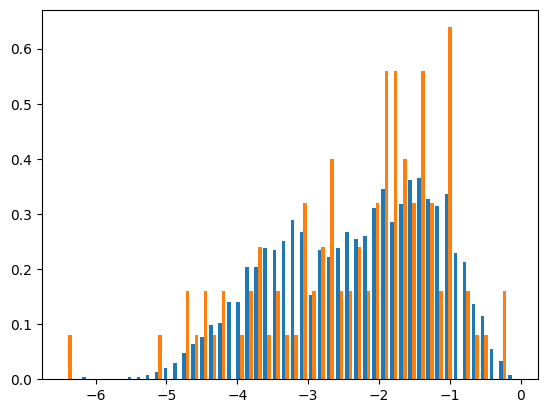

In [13]:
plt.hist(
    [x1, xg1],
    bins=50,
    density=True,
);

In [14]:
scipy.stats.ks_2samp(x1, xg1)

KstestResult(statistic=np.float64(0.0830301685891748), pvalue=np.float64(0.5146220233439168), statistic_location=np.float64(-1.9489743814979181), statistic_sign=np.int8(1))

In [15]:
scipy.stats.ttest_ind(x1, xg1)

TtestResult(statistic=np.float64(-0.2514191941048721), pvalue=np.float64(0.8015167126114566), df=np.float64(1936.0))

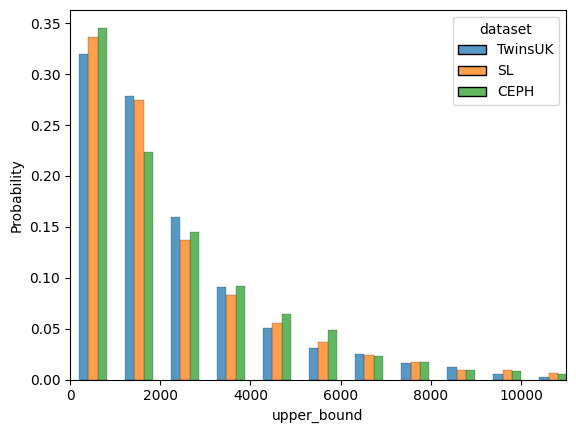

In [16]:
sns.histplot(
    data = NCO_df.to_pandas(),
    x = "upper_bound",
    hue = "dataset",
    stat = "probability",
    multiple = "dodge",
    common_norm = False,
    shrink = 0.6,
    bins = np.linspace(0, 50000, 50),
)

plt.xlim(0, 11000);

In [17]:
NCO_df.group_by("dataset", "n_converted").len().sort("dataset", "n_converted")

dataset,n_converted,len
str,i64,u32
"""CEPH""",1,907
"""CEPH""",2,4
"""SL""",1,709
"""SL""",2,24
"""SL""",3,3
"""SL""",4,2
"""TwinsUK""",1,1131
"""TwinsUK""",2,55
"""TwinsUK""",3,9


In [18]:
NCO_df.group_by("dataset").agg(pl.col("n_converted").mean().alias("mean")).sort("dataset")

dataset,mean
str,f64
"""CEPH""",1.004391
"""SL""",1.04878
"""TwinsUK""",1.074167


In [19]:
NCO_df.group_by("dataset").agg(pl.col("upper_bound").mean().alias("mean")).sort("dataset")

dataset,mean
str,f64
"""CEPH""",2509.453348
"""SL""",2363.822493
"""TwinsUK""",2298.75


In [20]:
scipy.stats.ks_2samp(
    NCO_df.filter(pl.col("dataset") != "CEPH")["upper_bound"],
    NCO_df.filter(pl.col("dataset") == "CEPH")["upper_bound"]    
)

KstestResult(statistic=np.float64(0.0492557991478988), pvalue=np.float64(0.09484411026999809), statistic_location=np.int64(2270), statistic_sign=np.int8(1))

In [21]:
scipy.stats.ttest_ind(
    NCO_df.filter(pl.col("dataset") != "CEPH")["upper_bound"],
    NCO_df.filter(pl.col("dataset") == "CEPH")["upper_bound"]    
)

TtestResult(statistic=np.float64(-1.9264796174448369), pvalue=np.float64(0.05414395056338729), df=np.float64(2847.0))

In [22]:
scipy.stats.ttest_ind(
    NCO_df.filter(pl.col("dataset") == "TwinsUK")["upper_bound"],
    NCO_df.filter(pl.col("dataset") == "CEPH")["upper_bound"]    
)

TtestResult(statistic=np.float64(-2.0140074571546407), pvalue=np.float64(0.04413551498624525), df=np.float64(2109.0))

In [23]:
scipy.stats.ks_2samp(
    NCO_df.filter(pl.col("dataset") != "CEPH")["n_converted"],
    NCO_df.filter(pl.col("dataset") == "CEPH")["n_converted"]    
)

KstestResult(statistic=np.float64(0.04617681609589933), pvalue=np.float64(0.136848703173717), statistic_location=np.int64(1), statistic_sign=np.int8(-1))

In [24]:
scipy.stats.ttest_ind(
    NCO_df.filter(pl.col("dataset") != "CEPH")["n_converted"],
    NCO_df.filter(pl.col("dataset") == "CEPH")["n_converted"]    
)

TtestResult(statistic=np.float64(5.748206011269795), pvalue=np.float64(9.976433436222115e-09), df=np.float64(2847.0))

In [25]:
print(scipy.stats.pearsonr(
        NCO_df["grch37_cM_per_bp_across_read"],
        NCO_df["upper_bound"],
    ))

PearsonRResult(statistic=np.float64(0.01770213021020072), pvalue=np.float64(0.34489954478529117))


In [26]:
print(scipy.stats.pearsonr(
    NCO_df["grch37_cM_per_bp_across_recombining_interval"],
    NCO_df["upper_bound"],
))

PearsonRResult(statistic=np.float64(-0.06565443428479656), pvalue=np.float64(0.000453839242122837))


In [27]:
for dataset in ["TwinsUK", "SL", "CEPH"]:
    print(dataset)
    print(scipy.stats.pearsonr(
        NCO_df.filter(pl.col("dataset") == dataset)["grch37_cM_per_bp_across_read"],
        NCO_df.filter(pl.col("dataset") == dataset)["upper_bound"],
    ))
    print(scipy.stats.spearmanr(
        NCO_df.filter(pl.col("dataset") == dataset)["grch37_cM_per_bp_across_read"],
        NCO_df.filter(pl.col("dataset") == dataset)["upper_bound"],
    ))

TwinsUK
PearsonRResult(statistic=np.float64(0.032244781738437964), pvalue=np.float64(0.2643715699791134))
SignificanceResult(statistic=np.float64(0.05226526023564271), pvalue=np.float64(0.07031565170616831))
SL
PearsonRResult(statistic=np.float64(0.027957488180423665), pvalue=np.float64(0.4482365197300917))
SignificanceResult(statistic=np.float64(0.09361591214159765), pvalue=np.float64(0.010944580368862651))
CEPH
PearsonRResult(statistic=np.float64(0.022205736509266223), pvalue=np.float64(0.5032447494976573))
SignificanceResult(statistic=np.float64(-0.0015539227190233392), pvalue=np.float64(0.96264287255526))


In [28]:
for dataset in ["TwinsUK", "SL", "CEPH"]:
    print(dataset)
    print(scipy.stats.pearsonr(
        NCO_df.filter(pl.col("dataset") == dataset)["grch37_cM_per_bp_across_recombining_interval"],
        NCO_df.filter(pl.col("dataset") == dataset)["upper_bound"],
    ))
    print(scipy.stats.spearmanr(
        NCO_df.filter(pl.col("dataset") == dataset)["grch37_cM_per_bp_across_recombining_interval"],
        NCO_df.filter(pl.col("dataset") == dataset)["upper_bound"],
    ))

TwinsUK
PearsonRResult(statistic=np.float64(-0.07659463376517209), pvalue=np.float64(0.007943758871622748))
SignificanceResult(statistic=np.float64(0.04294025097539004), pvalue=np.float64(0.13711271465005562))
SL
PearsonRResult(statistic=np.float64(-0.07630824051866883), pvalue=np.float64(0.03821789418752581))
SignificanceResult(statistic=np.float64(0.05009499924602415), pvalue=np.float64(0.17400868871360292))
CEPH
PearsonRResult(statistic=np.float64(0.0017364408979776745), pvalue=np.float64(0.9582588269351359))
SignificanceResult(statistic=np.float64(0.02145703572597845), pvalue=np.float64(0.5177496181074879))


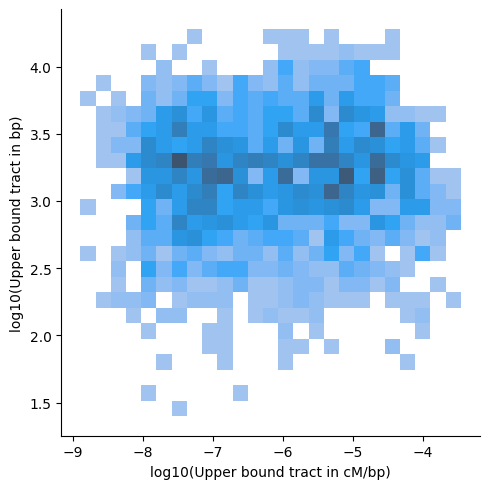

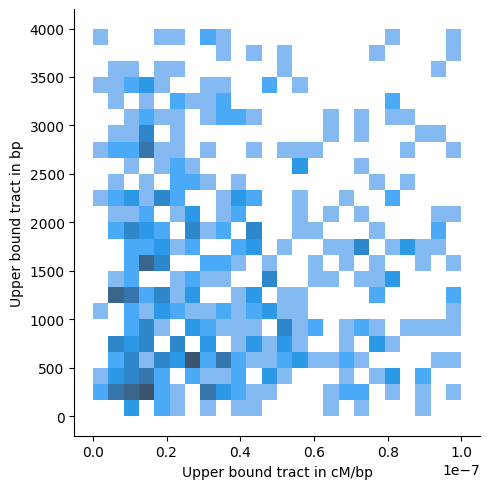

In [29]:
df = (NCO_df
    .filter(pl.col("dataset") != "CEPH")
    .filter(pl.col("grch37_cM_per_bp_across_recombining_interval").is_not_nan())
    .filter(pl.col("grch37_cM_per_bp_across_recombining_interval") > 0)
)

sns.displot(
    x=df["grch37_cM_per_bp_across_recombining_interval"].log(base=10),
    y=df["upper_bound"].log(base=10),
    bins=25,
);

plt.xlabel("log10(Upper bound tract in cM/bp)");
plt.ylabel("log10(Upper bound tract in bp)");

sns.displot(
    x=df["grch37_cM_per_bp_across_recombining_interval"],
    y=df["upper_bound"],
    bins=[np.linspace(0, 1e-7, 25), np.linspace(0, 4000, 25)],
);

plt.xlabel("Upper bound tract in cM/bp");
plt.ylabel("Upper bound tract in bp");




# Reviewer 1 Major point 1

In [33]:
tdf = (NCO_df
    .filter(pl.col("sample_id").is_in(rahbari_sample_ids + sudmant_sample_ids))
    .with_columns(multi_tract = pl.col("n_converted") > 1)
)

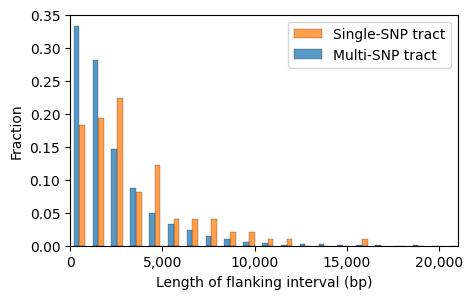

In [43]:
plt.figure(figsize=(5,3));

sns.histplot(
    data = tdf.to_pandas(),
    x = "upper_bound",
    hue = "multi_tract",
    stat = "probability",
    multiple = "dodge",
    common_norm = False,
    shrink = 0.6,
    bins = np.linspace(0, 50000, 50),
)

plt.xlim(0, 21000);
plt.xlabel("Length of flanking interval (bp)");
plt.ylabel("Fraction");
plt.legend(["Single-SNP tract","Multi-SNP tract"]);
plt.xticks([0,5000,10000,15000,20000],["0" ,"5,000", "10,000", "15,000", "20,000"]);

In [44]:
print(tdf.filter(pl.col("n_converted") == 1)["upper_bound"].mean())
print(tdf.filter(pl.col("n_converted") > 1)["upper_bound"].mean())

2265.5070652173913
3412.938775510204


In [32]:
scipy.stats.ks_2samp(
    NCO_df.filter(pl.col("n_converted") == 1)["upper_bound"],
    NCO_df.filter(pl.col("n_converted") > 1)["upper_bound"],
)

KstestResult(statistic=np.float64(0.23104349129531682), pvalue=np.float64(4.245806447491921e-05), statistic_location=np.int64(2090), statistic_sign=np.int8(1))